# The Music of the Sphere: 100 Posterior Sample Planck CMB Temperature Maps, and their Spherical Harmonic Decompositions

*Phil Marshall, Ingrid Gunn and Hans-Christian Eriksen, August 2015*

In this notebook we download 100 posterior sample Commander Planck CMB temperature maps, decompose them into spherical harmonics, and look at the statistics of the first few components.

In [1]:
%load_ext autoreload
%autoreload 2

In [7]:
%matplotlib inline
import beatbox
import healpy as hp
import os.path
import glob

## 1. Unpacking the Samples

Lets download the tarball containing 100 posterior sample ["COMMANDER-Ruler"](http://wiki.cosmos.esa.int/planckpla/index.php/CMB_and_astrophysical_component_maps#COMMANDER-Ruler) low resolution maps. It's 574Mb in size, so might take a few minutes to download.

In [8]:
tarball = "commander_32band_Clsamples100.tar.gz"
datadir = "data/commander_32band_Clsamples100/"

if not os.path.isfile(tarball):
    URL = "http://folk.uio.no/ingunnkw/planck/32band/"+tarball
    !wget -O "$tarball" "$URL"
    !tar xvfz "$tarball"
    !mkdir -p "$datadir"
    !mv cmb_Cl_c000*.fits "$datadir"

Good. Now, let's read each T map in to a "beatbox" Universe model, decompose it into spherical harmonics, and write out and visualize the lowest 10 l-modes.

In [12]:
Tmapfiles = glob.glob(datadir+"cmb_Cl_c000*.fits")
Nmaps = len(Tmapfiles)
We = [None]*len(Tmapfiles) # We are now legion!

for k in range(Nmaps):
    We[k] = beatbox.Universe()
    We[k].read_in_CMB_T_map(from_this=Tmapfiles[k])
    We[k].decompose_T_map_into_spherical_harmonics()
    # We[k].show_lowest_spherical_harmonics_of_CMB_T_map(lmax=10,max=100)
    We[k].write_out_spherical_harmonic_coefficients(lmax=10)

NSIDE = 256
ORDERING = RING in fits file
121 alm's (lmax = 10 ) written to data/commander_32band_Clsamples100/cmb_Cl_c0001_k00030_alm_lmax10.txt
NSIDE = 256
ORDERING = RING in fits file
121 alm's (lmax = 10 ) written to data/commander_32band_Clsamples100/cmb_Cl_c0001_k00031_alm_lmax10.txt
NSIDE = 256
ORDERING = RING in fits file
121 alm's (lmax = 10 ) written to data/commander_32band_Clsamples100/cmb_Cl_c0001_k00032_alm_lmax10.txt
NSIDE = 256
ORDERING = RING in fits file
121 alm's (lmax = 10 ) written to data/commander_32band_Clsamples100/cmb_Cl_c0001_k00033_alm_lmax10.txt
NSIDE = 256
ORDERING = RING in fits file
121 alm's (lmax = 10 ) written to data/commander_32band_Clsamples100/cmb_Cl_c0001_k00034_alm_lmax10.txt
NSIDE = 256
ORDERING = RING in fits file
121 alm's (lmax = 10 ) written to data/commander_32band_Clsamples100/cmb_Cl_c0001_k00035_alm_lmax10.txt
NSIDE = 256
ORDERING = RING in fits file
121 alm's (lmax = 10 ) written to data/commander_32band_Clsamples100/cmb_Cl_c0001_k00036_

Let's take a look at one or two of the samples:

Displaying sky map of the l =  10  and lower spherical harmonics only...
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


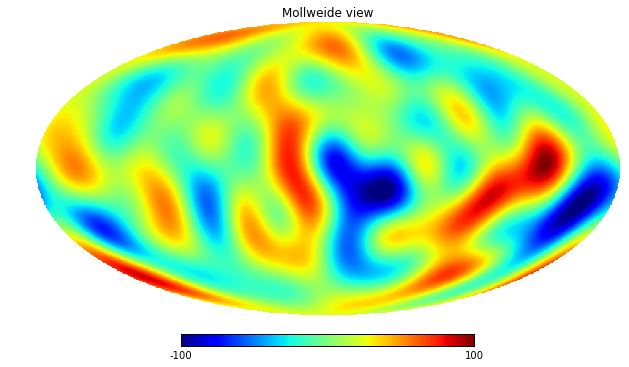

In [15]:
k = 53
We[k].show_lowest_spherical_harmonics_of_CMB_T_map(lmax=10,max=100)

Displaying sky map of the l =  10  and lower spherical harmonics only...
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


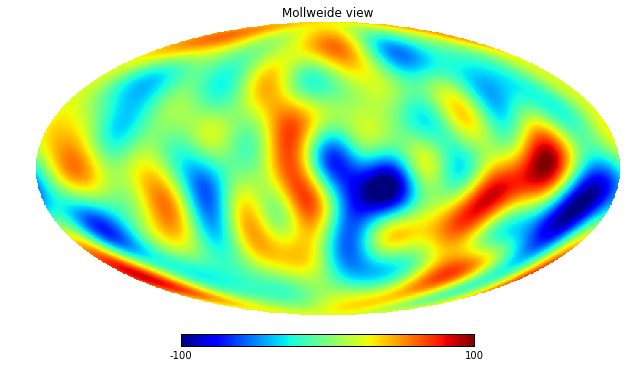

In [17]:
k = 37
We[k].show_lowest_spherical_harmonics_of_CMB_T_map(lmax=10,max=100)

Displaying sky map of the l =  10  and lower spherical harmonics only...
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


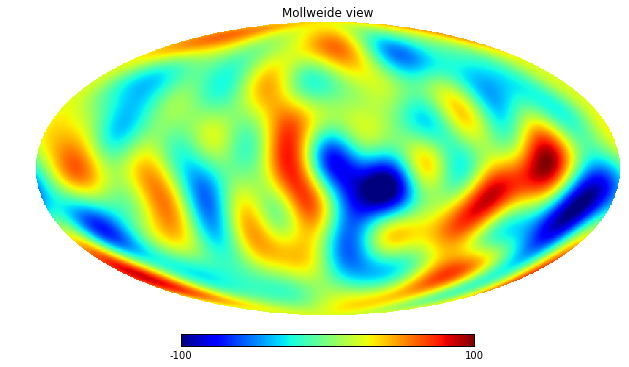

In [18]:
k = 7
We[k].show_lowest_spherical_harmonics_of_CMB_T_map(lmax=10,max=100)

Variations are noticeable but slight - Planck took *great* data.

## 2. Statistics of the Spherical Harmonics

For a weighted potential inversion, assuming a multivariate Gaussian distribution of coefficients, we would need the covariance matrix of the `alm`'s. Let's compute that and see how correlated they are.